In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.cm import ScalarMappable
from wrf_helpers import get_zgrid_XZcontour as zgrid
from wrf_helpers import get_vel_XZquiver
from wrf_helpers import get_XZgrid_XZquiver as XZgrid

In [2]:
# Global path = "/global/scratch/users/adac/Slope_Flow/SlopeFlow/WRFV3/LES3/"
# Template file = "wrfout_d01_2014-03-21_12:00:00"
# Template time = b'2014-03-21_12:00:00' i.e. it is byte string from the wrfout

# times = [ b'2014-03-22_04:00:00', b'2014-03-22_04:30:00', b'2014-03-22_05:00:00' ]
times = [ b'2014-03-21_19:30:00', b'2014-03-21_21:30:00', b'2014-03-21_23:00:00' ]
varStr = 'U'

path = "../WRFV3/LES3"
file= "wrfout_d01_2014-03-21_12:00:00"

In [3]:
ds = xr.open_dataset(path+'/'+file)#+'.nc')
ds

<xarray.Dataset>
Dimensions:                (Time: 121, south_north: 149, west_east: 399,
                            bottom_top: 68, bottom_top_stag: 69,
                            soil_layers_stag: 4, west_east_stag: 400,
                            south_north_stag: 150)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 ...
    XLONG                  (Time, south_north, west_east) float32 ...
    XTIME                  (Time) datetime64[ns] ...
    XLAT_U                 (Time, south_north, west_east_stag) float32 ...
    XLONG_U                (Time, south_north, west_east_stag) float32 ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 ...
    XLONG_V                (Time, south_north_stag, west_east) float32 ...
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, south_north_stag
Data variables: (12/153)
    Times                  (Time) |S19 ...
    LU_INDEX               (Time, south_north, west_east) float32 ...
    ZNU                    (Time, bottom_top) float32 ...
    ZNW                    (Time, bottom_top_stag) float32 ...
    ZS                     (Time, soil_layers_stag) float32 ...
    DZS                    (Time, soil_layers_stag) float32 ...
    ...                     ...
    PCB                    (Time, south_north, west_east) float32 ...
    PC                     (Time, south_north, west_east) float32 ...
    LANDMASK               (Time, south_north, west_east) float32 ...
    LAKEMASK               (Time, south_north, west_east) float32 ...
    SST                    (Time, south_north, west_east) float32 ...
    SST_INPUT              (Time, south_north, west_east) float32 ...
Attributes: (12/119)
    TITLE:                            OUTPUT FROM WRF V3.9.1.1 MODEL
    START_DATE:                      2014-03-21_12:00:00
    SIMULATION_START_DATE:           2014-03-21_12:00:00
    WEST-EAST_GRID_DIMENSION:        400
    SOUTH-NORTH_GRID_DIMENSION:      150
    BOTTOM-TOP_GRID_DIMENSION:       69
    ...                              ...
    ISLAKE:                          0
    ISICE:                           0
    ISURBAN:                         0
    ISOILWATER:                      0
    HYBRID_OPT:                      -1
    ETAC:                            0.0

In [4]:
nt = len(times)
itimes = [ds['Times'].values.tolist().index(times[i]) for i in range(nt)]
if nt<3:
    figsize = (10, 6) # Good for 2 times
else:
    figsize = (10, 8) # Good for 3 times

In [5]:
dims = ds[varStr].dims
assert len(dims)==4
nx = ds.dims[dims[-1]]
ny = ds.dims[dims[-2]]
iy = ny//2 
nz = ds.dims[dims[1]]

In [6]:
dx = ds.attrs['DX']
# if dims[-1]=="west_east_stag":
xuv = np.arange(0,nx*dx,dx)
# elif dims[-1]=="west_east":
xcv = np.arange(dx/2,nx*dx-dx/2,dx)

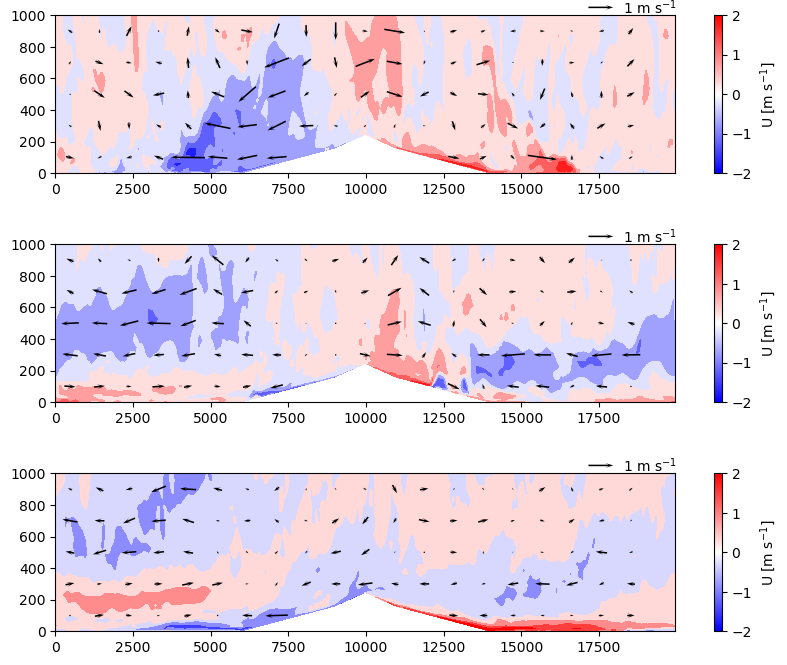

In [7]:
try:
    del(fig, axs, cf, cbar)
    print("deleted old figure")
    fig, axs = plt.subplots( nt, 1, figsize=figsize )
except:
    fig, axs = plt.subplots( nt, 1, figsize=figsize )

if varStr == "W":
    cbarLabels = nt*[r'vertical velocity [m s$^{-1}$]']
else:
    cbarLabels = nt*[r''+varStr+r' [m s$^{-1}$]']

vmin = -2
vmax = 2
cbarTicks = np.linspace(vmin,vmax,5)
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
mappable = ScalarMappable(norm=norm, cmap='bwr')

ztop = 1000 # [m a.s.l.]
ktop = 38 # just for speed, make sure higher than ztop everywhere
x_u = np.tile(xuv, (ktop,1))
x_c = np.tile(xcv, (ktop,1))
x_w = np.tile(xcv, (ktop+1,1))

dX=950
X,Z = XZgrid(dX,(nx-1)*dx/dX,ztop,5)
HGT = np.interp(X, xcv, ds['HGT'][0,iy].values)
mask = Z < HGT

for it, itime in enumerate(itimes):
    axs[it].set_ylim( (0, ztop) )

    z_c, z_u, z_w = zgrid(ds, itime, ktop, iy)

    u, w = get_vel_XZquiver(ds['U'][itime, :ktop, iy], ds['W'][itime, :ktop+1, iy], 
                            x_u, x_w, z_u, z_w, X, Z, mask)

    if dims[1]=="bottom_top_stag":
        cf = axs[it].contourf(x_w, z_w, ds[varStr][itime,:ktop+1,iy,:], cmap="bwr", norm=norm)
        
    elif dims[-1]=="west_east_stag":
        cf = axs[it].contourf(x_u, z_u, ds[varStr][itime,:ktop,iy,:], cmap="bwr", norm=norm)
   

    cbar = fig.colorbar( mappable,
                        ax=axs[it],
                        norm=norm, 
                        cmap="bwr",label=cbarLabels[0], ticks = cbarTicks
                        ) 
       
        
    qv = axs[it].quiver(X, Z, u, w, angles= 'uv',# scale_units='uv', 
                        scale=25,         # Larger -> shorter arrows (adjust experimentally)
                        width=0.0025,      # Thinner shafts than default (~0.005)
                        headwidth=3,      # Default is 3, but reducing vertical bulk
                        headlength=5,     # Default is 5, smaller head in stretched axes
                        headaxislength=3, # Controls head flare; keep small
                        pivot='middle'    # Center pivot helps in stretched plots
                       )

    axs[it].quiverkey(qv,
                X=0.9, Y=1.05,    # position in axes fraction coords (0–1)
                U=1,              # vector magnitude represented
                label=r'1 m s$^{-1}$',    # label text
                labelpos='E'      # 'N', 'S', 'E', 'W' for label position
                )
    

    # cbar.set_ticks(cbarTicks) 
    # cbar.set_lim( (vmin, vmax) )
    
fig.subplots_adjust(hspace=0.45)

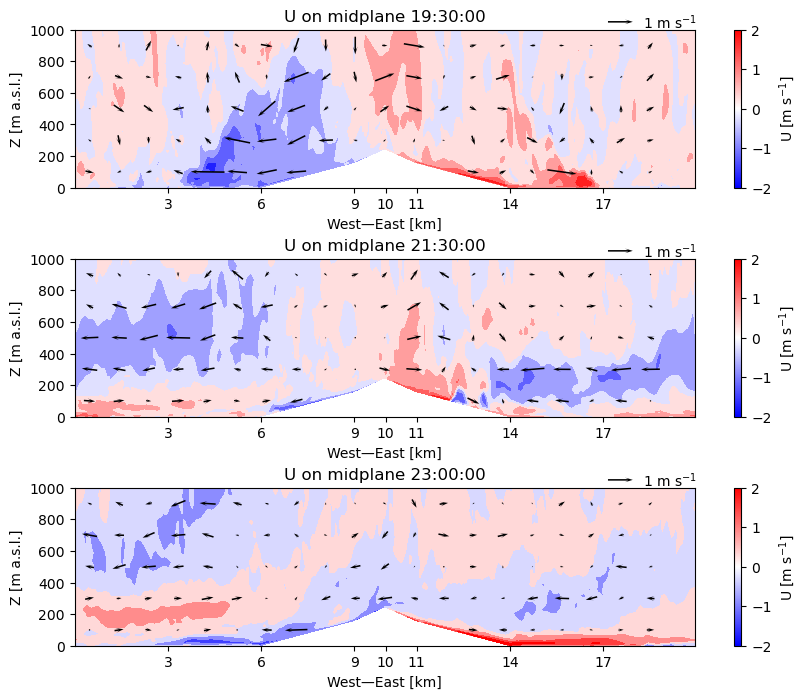

In [8]:
title_spec = nt*[""]
for it, itime in enumerate(itimes):
    # axs[it].set_ylim( (0, ztop) )
    axs[it].set_ylabel("Z [m a.s.l.]")
    axs[it].set_xlabel('West\u2014East [km]')
    axs[it].set_title(varStr+" on midplane "+title_spec[it]+times[it][-8:].decode())
    axs[it].set_xticks( [3e3, 10e3 - 4e3, 10e3 - 1e3, 10e3, 10e3 + 1e3, 10e3 + 4e3, 20e3 - 3e3] )
    axs[it].set_xticklabels( ["3", "6", "9", "10", "11", "14", "17"] )
    axs[it].set_xlim( [ 0 , 20e3 - dx] )

fig

In [9]:
save=True
if save:
    plt.figure(fig)
    fmts=["png","eps"]
    for fmt in fmts:
        plt.savefig("plots/XZ_initial"+varStr+"."+fmt, format=fmt)